<a href="https://colab.research.google.com/github/cRaeber/FacialRecognitionWithDeepLearning/blob/main/Pre-Trained%20Models/PreTrainedModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Data Upload

In [ ]:
import numpy as np
import seaborn as sns
# from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import image

import os
from os import listdir
import zipfile
from google.colab import drive

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import random
import glob
import shutil


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/GradSchool/DeepLearning/Project/Take2/FacesSplit/Train/',
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 1248 files belonging to 2 classes.


In [ ]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/GradSchool/DeepLearning/Project/Take2/FacesSplit/Val/',
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 350 files belonging to 2 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/GradSchool/DeepLearning/Project/Take2/FacesSplit/Test/',
  image_size=(img_height, img_width),
  batch_size = batch_size)

Found 176 files belonging to 2 classes.


Augemtor 

In [ ]:
data_augmentation= keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.5),
     layers.RandomZoom(0.2),
     layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode="constant"),
    ])

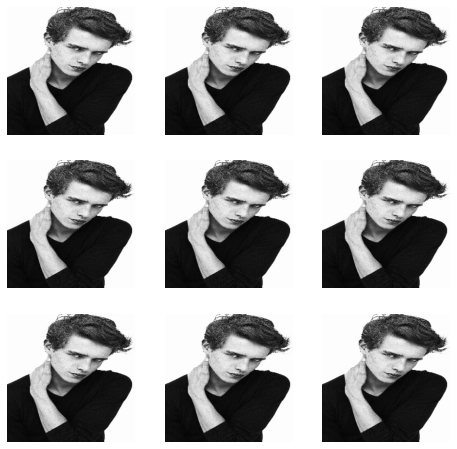

In [ ]:
plt.figure(figsize=(8,8))
for images, _ in train_ds.take(1):
  for i in range(9):
    aug = data_augmentation(images)
    ax= plt.subplot(3,3,i+1)
    plt.imshow(aug[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#ResNet
inputs = keras.Input(shape=(img_height, img_width, 3))

x0 = data_augmentation(inputs)
x0 = layers.Rescaling(1./255)(inputs)

x0 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x0)
residual = x0
x0 = layers.Conv2D(filters=16, kernel_size=3, activation="relu", padding = "same")(x0)
residual = layers.Conv2D(16, 1) (residual)
x0 = layers.add([x0, residual])

x0 = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x0)
x0 = layers.Conv2D(filters=4, kernel_size=3, activation="relu")(x0)
x0 =layers.Flatten()(x0)
outputs = layers.Dense(1, activation="sigmoid")(x0)
model0 = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#DenseNet
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(n_classes, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model
input_shape = img_height, img_width, 3
n_classes = 1
model1 = densenet(input_shape,n_classes)

In [ ]:
img_augmentation = Sequential(
    [
        # Resizing input to better match ImageNet size
        preprocessing.Resizing(256, 256),
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

def build_model(num_classes, input_image_size):
    inputs = layers.Input(shape=(input_image_size, input_image_size, 3))
    x = img_augmentation(inputs)

    model = tf.keras.applications.NASNetMobile(
        input_shape=None,
        include_top=False,
        weights="imagenet",
        input_tensor=x,
        pooling=None,
        classes=num_classes,
    )

    # Freeze the pretrained weights
    model.trainable = False

    # Unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # Rebuild non-frozen top layers of NASNetMobile, which was initialized with include_top=False
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="NASNetMobile")
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model2 = build_model(1, img_width)

In [ ]:
from keras.applications.vgg16 import VGG16
inputs = 224, 224, 3
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=inputs)
model3 = tf.keras.models.Sequential()
model3.add(conv_base)
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
input_t = tf.keras.Input(shape=(224, 224, 3))
res_model = tf.keras.applications.ResNet50(include_top = False,
                             weights = "imagenet",
                             input_tensor=input_t)

model4 = tf.keras.models.Sequential()
model4.add(res_model)
model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
model0.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
filepath0="weights0-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
filepath1="weights1-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
filepath2="weights2-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
filepath3="weights3-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
filepath4="weights4-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"

checkpoint0 = ModelCheckpoint(filepath0, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint3 = ModelCheckpoint(filepath3, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint4 = ModelCheckpoint(filepath4, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=32)

In [ ]:
history0 = model0.fit(train_ds, validation_data = valid_ds, epochs = 128, batch_size=16, callbacks=[checkpoint0, earlyStop])
history1 = model1.fit(train_ds, validation_data = valid_ds, epochs = 128, batch_size=16, callbacks=[checkpoint1, earlyStop])
history2 = model2.fit(train_ds, validation_data = valid_ds, epochs = 128, batch_size=16, callbacks=[checkpoint2, earlyStop])
history3 = model3.fit(train_ds, validation_data = valid_ds, epochs = 128, batch_size=16, callbacks=[checkpoint3, earlyStop])
history4 = model4.fit(train_ds, validation_data = valid_ds, epochs = 128, batch_size=16, callbacks=[checkpoint4, earlyStop])

## Evaluation of Models using Data Augmentation

In [ ]:
def learning_curve (history):
  fig, axs = plt.subplots(1, 2, constrained_layout= True)
  axs[0].set_ylim(-0.1, 1.10)
  axs[1].set_ylim(-0.1, 1.10)
  fig.suptitle('Training Performance')
  axs[0].plot(history.history['accuracy'], label='Training Accuracy') 
  axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  axs[0].legend()
  axs[0].set_title('Accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].set_xlabel('Epoch')

  axs[1].plot(history.history['loss'], label='Training Loss')
  axs[1].plot(history.history['val_loss'], label = 'Validation Loss')
  axs[1].legend()
  axs[1].set_title('Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  plt.show()

In [ ]:
def model_accuracy (X, Y, model, prediction):
  print("Test Data Results:")
  scores = model.evaluate(X, Y)
  for i in range(len(scores)):
    print("%s: %.3f%%" % (model.metrics_names[i], scores[i]*100))

  accuracy = accuracy_score(Y, prediction.round()) * 100
  precision = precision_score(Y, prediction.round()) * 100
  recall = recall_score(Y, prediction.round()) * 100
  f1score = f1_score(Y, prediction.round())
  
  print("Accuracy Score: %.6s%%" % (accuracy))
  print("Precision Score: %.6s%%" % (precision))
  print("Recall Score: %.6s%%" % (recall))
  print("F1 Score: %.6s" % (f1score))

In [ ]:
#batch size must be the entire test set
X_Length = 176

batch_size = X_Length
img_height = 224
img_width = 224
eval_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/GradSchool/DeepLearning/Project/Take2/FacesSplit/Test/',
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size)

for images, labels in eval_ds.take(1):
  xtest = images.numpy()
  ytest = labels.numpy()
print(ytest.shape)
print(xtest.shape)

Found 176 files belonging to 2 classes.
(176,)
(176, 224, 224, 3)


Model0:
Test Data Results:
6/6 [==============================] - 0s 17ms/step - loss: 0.4002 - accuracy: 0.9148
loss: 40.023%
accuracy: 91.477%
Accuracy Score: 91.477%
Precision Score: 93.600%
Recall Score: 94.354%
F1 Score: 0.9397


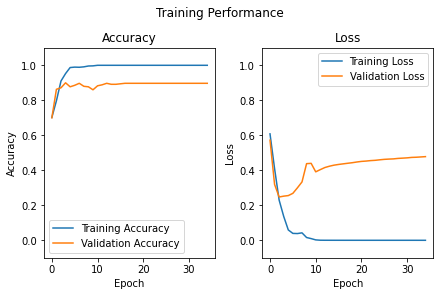

In [ ]:
prediction = model0.predict(xtest)
print("Model0:")
model_accuracy(xtest, ytest, model0, prediction)
learning_curve(history0)

Model1:
Test Data Results:
6/6 [==============================] - 0s 57ms/step - loss: 0.0917 - accuracy: 0.7045
loss: 9.169%
accuracy: 70.455%
Accuracy Score: 70.454%
Precision Score: 70.454%
Recall Score: 100.0%
F1 Score: 0.8266


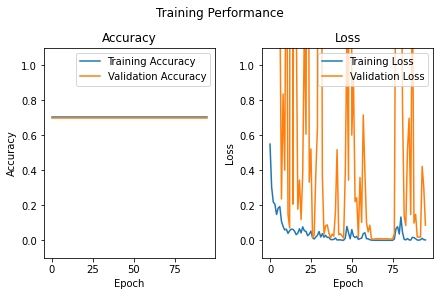

In [ ]:
prediction = model1.predict(xtest)
print("Model1:")
model_accuracy(xtest, ytest, model1, prediction)
learning_curve(history1)

Model2:
Test Data Results:
6/6 [==============================] - 0s 57ms/step - loss: 0.2475 - accuracy: 0.8750
loss: 24.750%
accuracy: 87.500%
Accuracy Score: 87.5%
Precision Score: 91.129%
Recall Score: 91.129%
F1 Score: 0.9112


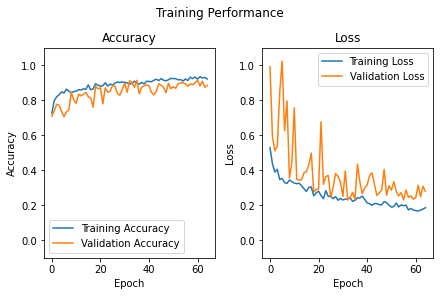

In [ ]:
prediction = model2.predict(xtest)
print("Model2:")
model_accuracy(xtest, ytest, model2, prediction)
learning_curve(history2)

Model3:
Test Data Results:
6/6 [==============================] - 0s 70ms/step - loss: 0.0671 - accuracy: 0.9886
loss: 6.709%
accuracy: 98.864%
Accuracy Score: 98.863%
Precision Score: 99.193%
Recall Score: 99.193%
F1 Score: 0.9919


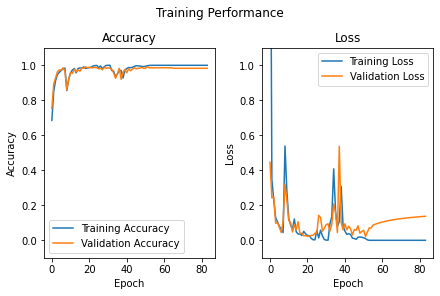

In [ ]:
prediction = model3.predict(xtest)
print("Model3:")
model_accuracy(xtest, ytest, model3, prediction)
learning_curve(history3)

Model4:
Test Data Results:
6/6 [==============================] - 0s 51ms/step - loss: 0.0634 - accuracy: 0.9659
loss: 6.339%
accuracy: 96.591%
Accuracy Score: 96.590%
Precision Score: 95.384%
Recall Score: 100.0%
F1 Score: 0.9763


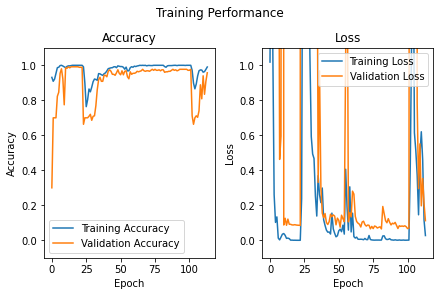

In [ ]:
prediction = model4.predict(xtest)
print("Model4:")
model_accuracy(xtest, ytest, model4, prediction)
learning_curve(history4)

In [ ]:
%%shell
jupyter nbconvert --to html /content/Phase6.ipynb

[NbConvertApp] Converting notebook /content/Phase6.ipynb to html
[NbConvertApp] Writing 709454 bytes to /content/Phase6.html
